# Modelo de Regresión Simple

In [1]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext=SQLContext(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/22 14:14:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/aldos/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("../bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Descripción Previa de la Base de Datos

Resumen Numérico

In [3]:
pdf4 = bd5.sample(False, 0.1, 0).select('Dest','Horario','ArrDelay','DepDelay','RetrasoNeto').toPandas()
pdf4.corr()

,Horario,ArrDelay,DepDelay,RetrasoNeto
Horario,1.000000,0.112710,0.101596,0.062927
ArrDelay,0.112710,1.000000,0.945805,0.435178
DepDelay,0.101596,0.945805,1.000000,0.119220
RetrasoNeto,0.062927,0.435178,0.119220,1.000000


Resumen Gráfico

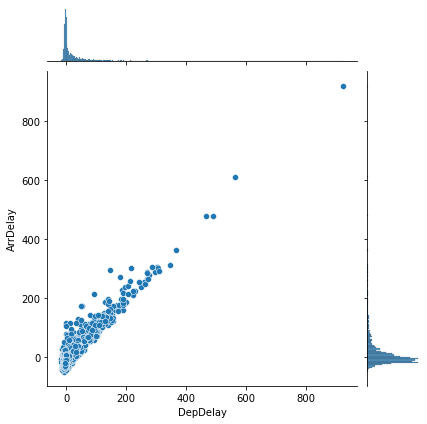

In [4]:
import seaborn as sns
%matplotlib inline
sns.jointplot(x="DepDelay", y="ArrDelay", data=pdf4)

## Configuración de la base de datos

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(
    inputCols=['DepDelay'],
    outputCol='features')

bd6 = assembler.transform(bd5).select(col("ArrDelay").alias("label"),'features')
bd6.show()

+-----+--------+
|label|features|
+-----+--------+
| -7.0|  [-5.0]|
| -3.0|   [5.0]|
| -3.0|  [-3.0]|
| -2.0|  [-7.0]|
| -2.0|  [-6.0]|
|  0.0|  [-1.0]|
| -6.0|   [0.0]|
|  7.0|   [0.0]|
| -9.0|  [-1.0]|
| -2.0|  [-1.0]|
| 13.0|   [1.0]|
|-16.0|  [-2.0]|
|-21.0|  [-4.0]|
|-16.0|  [-1.0]|
|-11.0|   [0.0]|
| -8.0|   [0.0]|
| -4.0|  [13.0]|
|  0.0|  [17.0]|
| -2.0|  [12.0]|
|  2.0|  [19.0]|
+-----+--------+
only showing top 20 rows



### Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

22/02/22 14:16:23 WARN Instrumentation: [9dcf7b9b] regParam is zero, which might cause numerical instability and overfitting.


Coeficientes

In [7]:
print(model.intercept,model.coefficients)

-4.399441080491326 [1.0278600247757472]


Modelo Teórico:

__ArrDelay = $\beta_0$ + $\beta_1$*DepDelay + $\epsilon$__ 


Modelo Predictivo:

__ArrDelay = -4.4 + 1.03*DepDelay__




Valores Predichos y Residuos

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------+-------------------+-------------------+
|label|features|         prediction|           residual|
+-----+--------+-------------------+-------------------+
| -7.0|  [-5.0]| -9.538741204370062|  2.538741204370062|
| -3.0|   [5.0]| 0.7398590433874102|  -3.73985904338741|
| -3.0|  [-3.0]| -7.483021154818568|  4.483021154818568|
| -2.0|  [-7.0]|-11.594461253921557|  9.594461253921557|
| -2.0|  [-6.0]| -10.56660122914581|   8.56660122914581|
|  0.0|  [-1.0]| -5.427301105267073|  5.427301105267073|
| -6.0|   [0.0]| -4.399441080491326| -1.600558919508674|
|  7.0|   [0.0]| -4.399441080491326| 11.399441080491325|
| -9.0|  [-1.0]| -5.427301105267073| -3.572698894732927|
| -2.0|  [-1.0]| -5.427301105267073|  3.427301105267073|
| 13.0|   [1.0]|-3.3715810557155788|  16.37158105571558|
|-16.0|  [-2.0]|  -6.45516113004282| -9.544838869957179|
|-21.0|  [-4.0]| -8.510881179594314|-12.489118820405686|
|-16.0|  [-1.0]| -5.427301105267073|-10.572698894732927|
|-11.0|   [0.0]| -4.39944108049

Representación gráfica de resultados

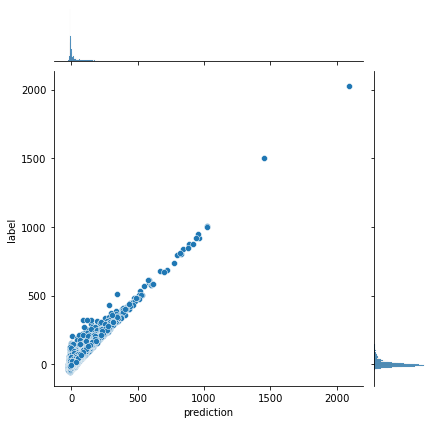

In [9]:
pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="label", data=pdpred)

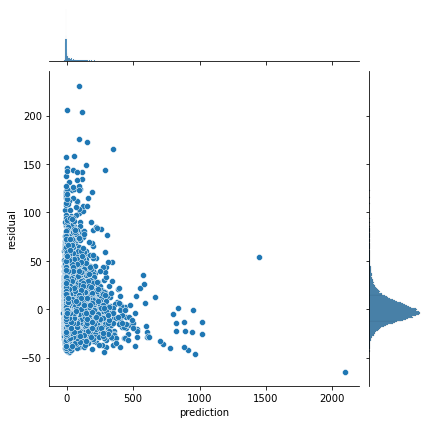

In [10]:
sns.jointplot(x="prediction", y="residual", data=pdpred)

Métricas de Evaluación (R2, RMSE, MAE)

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.498421344920214
0.9161065747950514


Otros parámetros opcionales del modelo

In [10]:
#lr = LinearRegression()
#lr = LinearRegression(
    #maxIter=5, 
    #regParam=0.0,
    #elasticNetParam=0.0,
    #solver="normal", 
    #weightCol="weight")